# Statistical Inference

In [14]:
library(dplyr)
library(ggplot2)
library(infer)
library(purrr)

# Problem Statement

Let's say we want to see what the average height for men and women is in the US

* We get info for people in R2 data labs

* Conclude heights of 5'10 for men and 5'5 for women

Consider the following questions:  

1. How representative is this conclusion of the entire US population?

2. Is there any tolerance to these values (+/-)?

3. How confident are we that this isn't due to randomization?


# Sampling

So why do we sample instead of gathering all the data of the population?

* Don't always have the resources to get the population

* Takes too much time to survey

* Insufficient computational resources for the dataset

Randomly Sample data

* Generalizations about a population require samples to be randomly gathered/selected

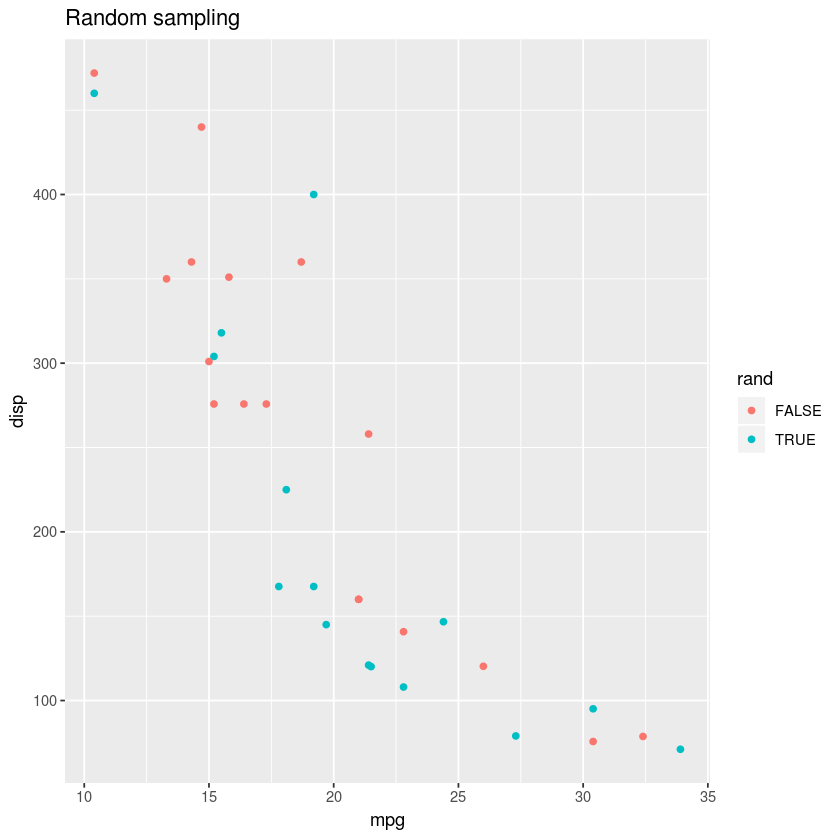

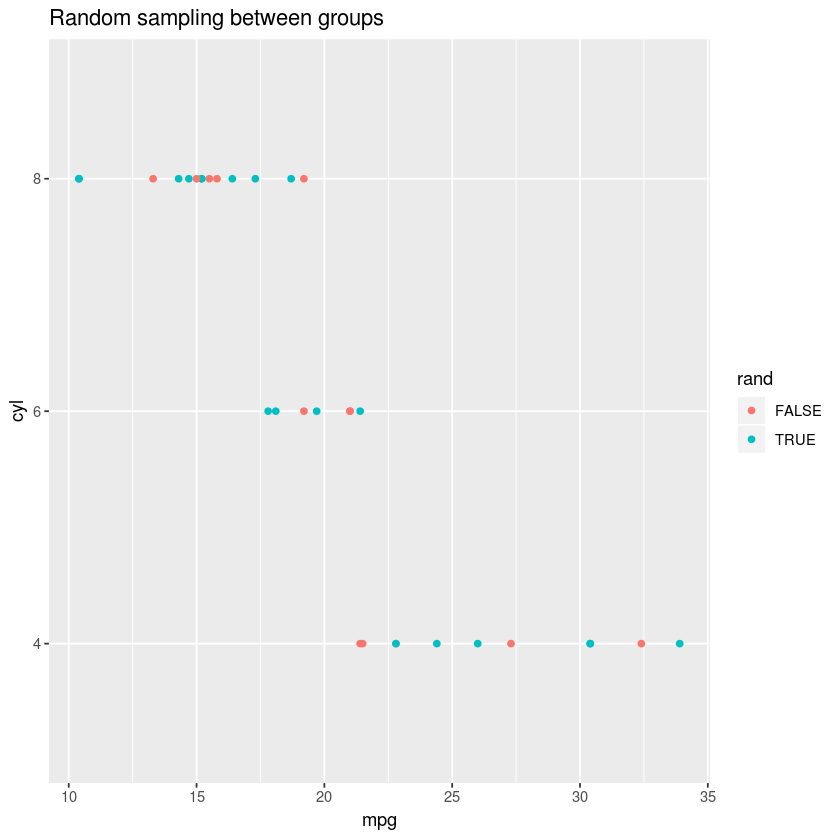

In [15]:
mtcars %>%
  mutate(rand = as.logical(sample(c(0,1), size = nrow(.), replace = T))) %>%
  ggplot(aes(x = mpg, y = disp)) + geom_point(aes(col = rand)) +
  ggtitle("Random sampling")

mtcars %>%
  mutate(rand = as.logical(sample(c(0,1), size = nrow(.), replace = T))) %>%
  ggplot(aes(x = mpg, y = as.factor(cyl))) + geom_point(aes(col = rand)) +
  ggtitle("Random sampling between groups") +
  ylab("cyl")

Understand the Problem Statement before moving forward. 

* Is this an Observational or Experimental Study?

This can help determine how data should be collected, or if the data collected have been done so in a manner that will allow for generalization or infer causation.


# Central Limit Theorem

*In probability theory, the central limit theorem (CLT) states that, given certain conditions, the arithmetic mean of a sufficiently large number of iterates of independent random variables, each with a well-defined expected value and well-defined variance, will be approximately normally distributed, regardless of the underlying distribution.*

## Normal Distribution

![Illustration of Central Limit Theorem (CLT)](IllustrationCentralTheorem.png)


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


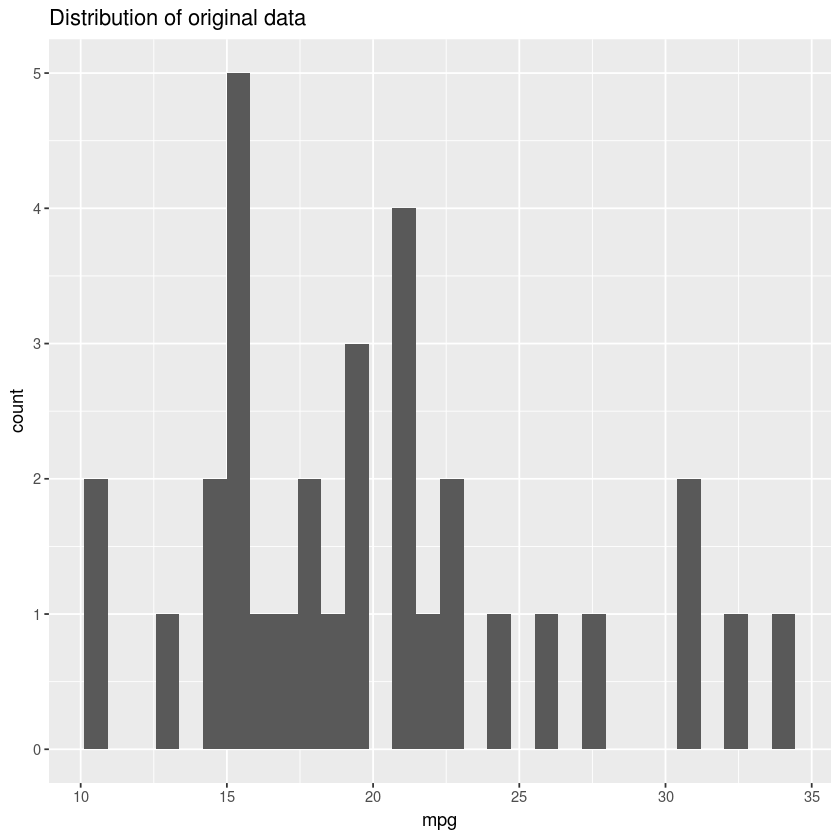

In [16]:
mtcars %>%
  ggplot(aes(x = mpg)) +
  geom_histogram() +
  ggtitle("Distribution of original data")

Now **RE-SAMPLE** the data **WITH** replacement (a.k.a Bootstrapping referenced in a later section) and gather the means of each sample and plot the distribution

This is the **SAMPLING DISTRIBUTION OF THE SAMPLE MEANS**

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


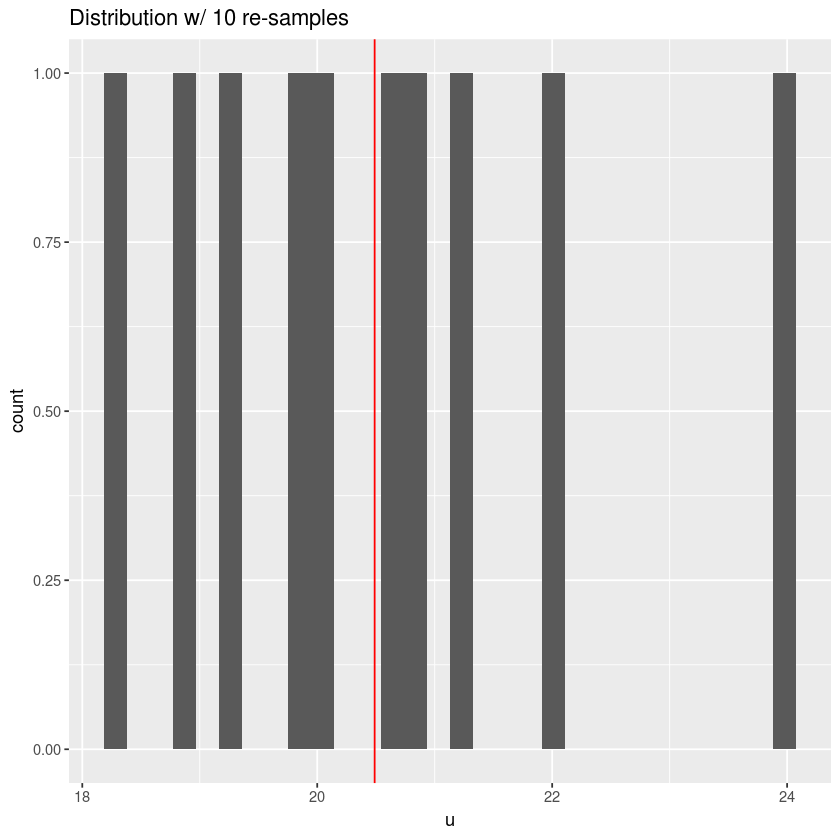

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


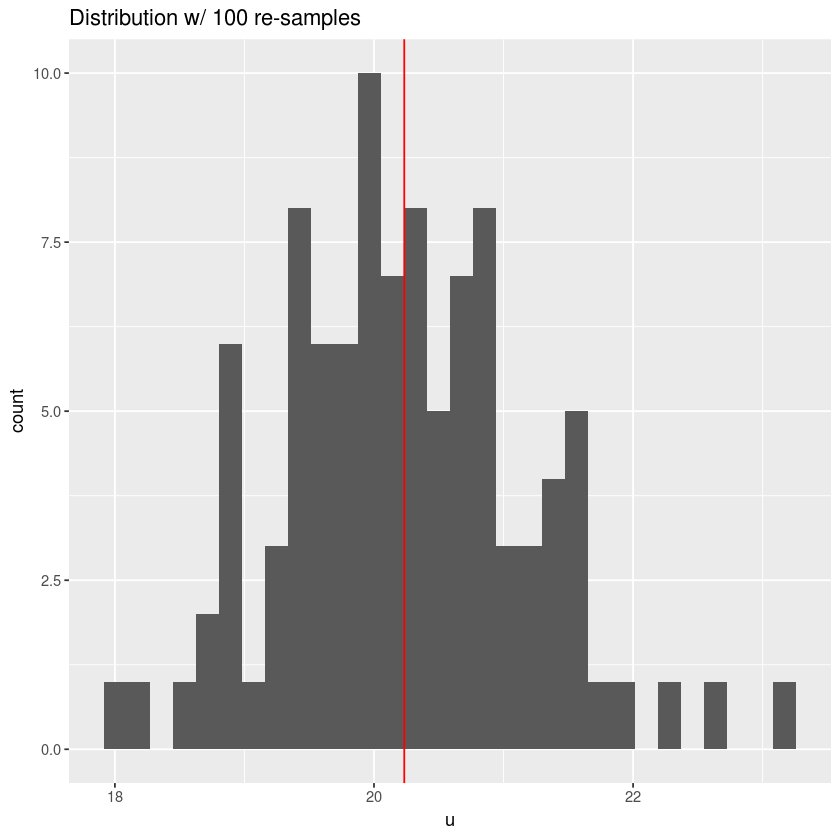

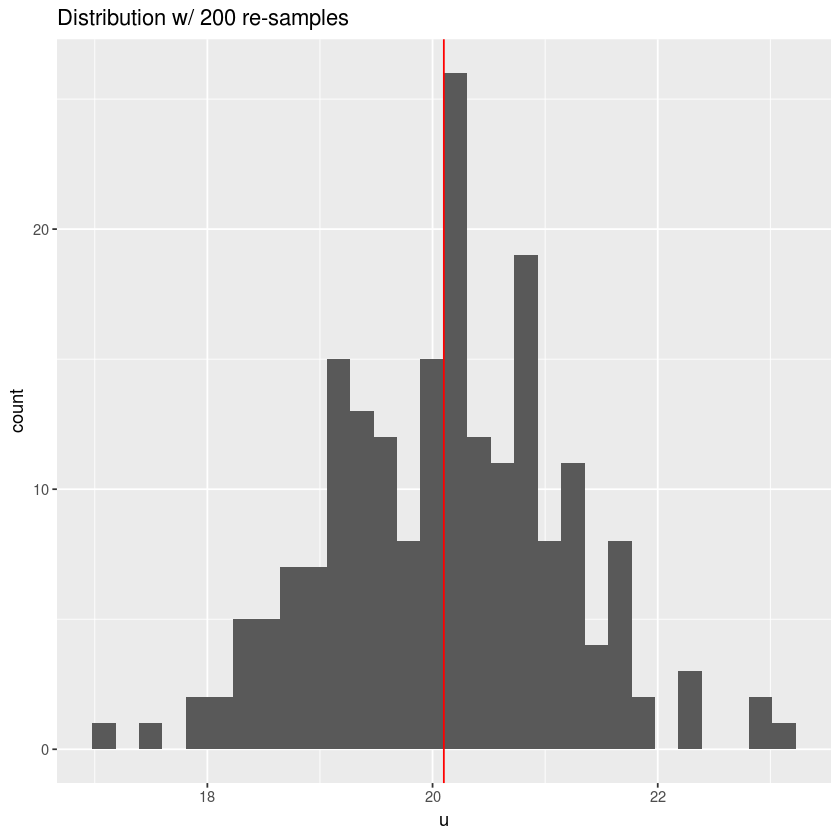

In [17]:
sampDist = function(x) {
  mtcars %>%
  select(mpg) %>%
  rep_sample_n(size = nrow(.), replace = T, reps = x) %>%
  group_by(replicate) %>%
  summarise(u = mean(mpg)) %>%
  ggplot() +
  geom_histogram(aes(u)) +
  geom_vline(aes(xintercept = mean(u)), col = "red") +
  ggtitle(paste0("Distribution w/ ", x, " re-samples"))
}

list(10, 100, 200) %>%
  map(sampDist) %>%
  walk(print)

# Confidence Intervals

Confidence Intervals represent an estimated range in which the population parmeter falls, given a desired confidence level.

Commonly Used Confidence Levels are: 90%, 95% and 99%.

$$C.I. = statistic - Critical Value * Standard Error, statistic + Critical Value * Standard Error$$

* Standard Error
    * Standard Deviation of the Sampling Distribution
    * S.E. = stdev~sample~/n^(1/2)^
* Confidence Intervals
    * E.g: For a 95% confidence level
        * Critical Value (aka Z-score) for a 95% confidence level = 1.96 ~= 2
        * $$C.I = stat - 2 * S.E., stat + 2 * S.E.$$

## Bootstrapping

1. Randomly sample from sample with replacement
    * E.g: Original Sample = 0,1,2,3
    * BS_Sample1 = 0,2,2,3
    * BS_Sample2 = 2,0,1,0
    * BS_Sample3 = 3,3,3,1
2. Get a statistic from each group (e.g the mean)
3. Creates sampling distribution of the sample statistic, in this case, the mean

In [18]:
data.frame(sampledata = c(0,1,2,3)) %>%
  generate(reps = 4, type = "bootstrap")

replicate,sampledata
1,0
1,2
1,2
1,1
2,2
2,2
2,1
2,2
3,2
3,2


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


lower,upper
18.0843,22.2532


lower,upper
18.02111,22.16014


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


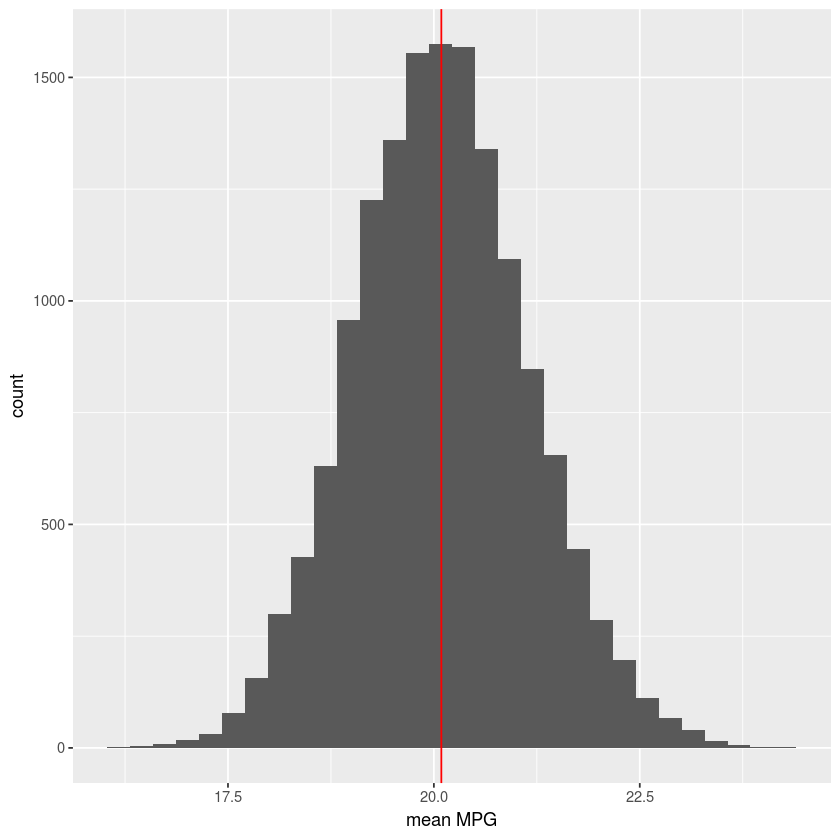

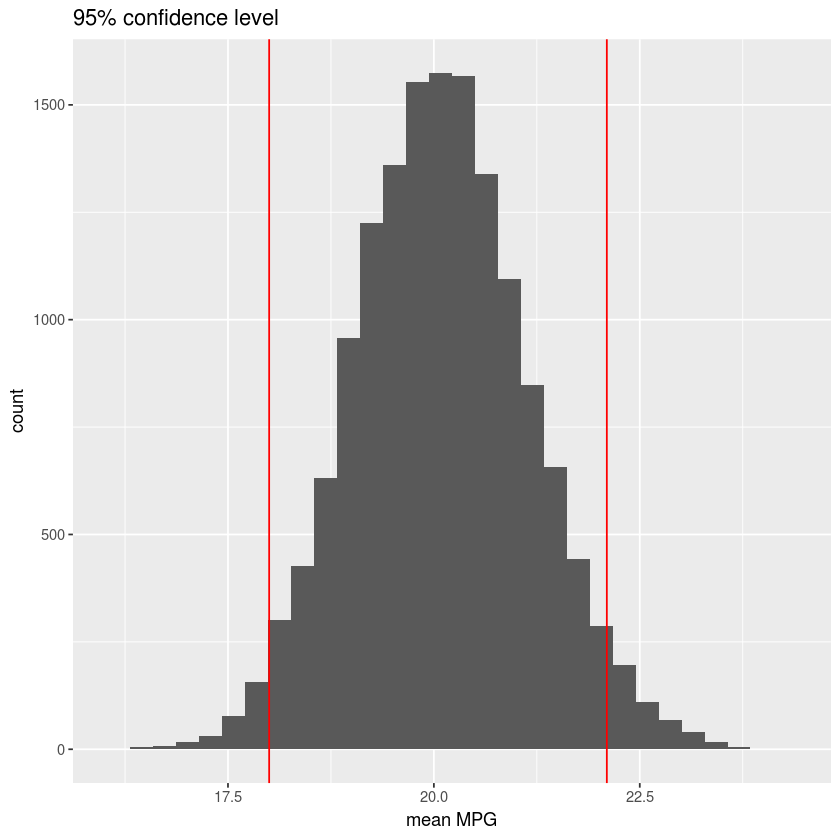

In [19]:
# First get the mean of "MPG" from the sample
avg_mpg = mtcars %>%
  summarise(mean(mpg)) %>%
  pull()

# Use bootstrapping to get a collection of means from resampling w/ replacement
data = mtcars %>%
  mutate(cyl = as.factor(cyl)) %>%
  specify(response = mpg) %>%
  generate(reps = 15000, type = "bootstrap") %>%
  calculate(stat = "mean")

# Plot the sampling distribution of the sample means & show the original mean
data %>%
  ggplot(aes(stat)) +
  geom_histogram() +
  geom_vline(aes(xintercept = avg_mpg), col = "red") +
  xlab("mean MPG")

# Quantile Method
# Get the upper and lower 2.5% thresholds for the distribution
data %>%
  summarise(lower = quantile(stat, 0.025),
            upper = quantile(stat, 0.975))


# Standard Error Method
# Get he z-value/critical value for the 95% confidence level
critVal = qt(0.975, df = nrow(data) - 1)

# Plug the data in to get the upper and lower thresholds that form the confidence interval
data %>%
  summarise(std_err = sd(data$stat)) %>%
  summarise(lower = mean(mtcars$mpg) - critVal * std_err,
            upper = mean(mtcars$mpg) + critVal * std_err)

# Plot the distribution witht the confidence intervals
data %>%
  ggplot(aes(stat)) + 
  geom_histogram() +
  geom_vline(xintercept = c(18, 22.1), col = "red") +
  ggtitle("95% confidence level") + xlab("mean MPG")

Put into words: If we re-sampled 100 times, the mean of the samples would range between 18 and ~22, most (95%) of the time.

Anything outside of the confidence intervals would likely happen 5% (1/20) of the time. In which case we could consider it to be *significantly different** from what we would expect to get.

# Hypothesis Testing

* Alternative Hypothesis (H~A~)
    * Hypothesis about something
* Null Hypothesis (H~0~)
    * Counter hypothesis that the Alternative is NOT True
    * **Does not verify any other scenario. Only verifies that the Alternative Hypothesis is NOT the case.**

* Why Hypothesis Testing/What is it?
    * We form a hypothesis (H~A~) based off of some suspicion due to data or previous experience
    * But how do we know that what formed this assumption wasn't due to radom chance?
    * That random chance is what forms our NULL HYPOTHESIS
    
1. Make our Alternative Hypothesis

In [20]:
observed_mean_diff = mtcars %>%
  filter(cyl != 8) %>%
  group_by(as.factor(cyl)) %>%
  summarise(mpg_avg = mean(mpg)) %>%
  pull() %>%
  diff() %>%
  abs()

observed_mean_diff

[1] 6.920779

H~A~:  There is a difference in the means between 4 and 6 cylinder cars

2. Take our original sample of data and replicate it

3. Break the relationships in the replicate by shuffling
    * This is what creates the randomization of the data samples

4. Permute Step 3 a number of times and take a sample statistic
    * This creates the Null Distribution (Distribution of the Null Hypothesis)

replicate,stat
1,3.55454545
2,0.93636364
3,1.63766234
4,1.70779221
5,2.40909091
6,-1.26103896
7,0.51558442
8,1.24025974
9,-2.00909091
10,2.87662338


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


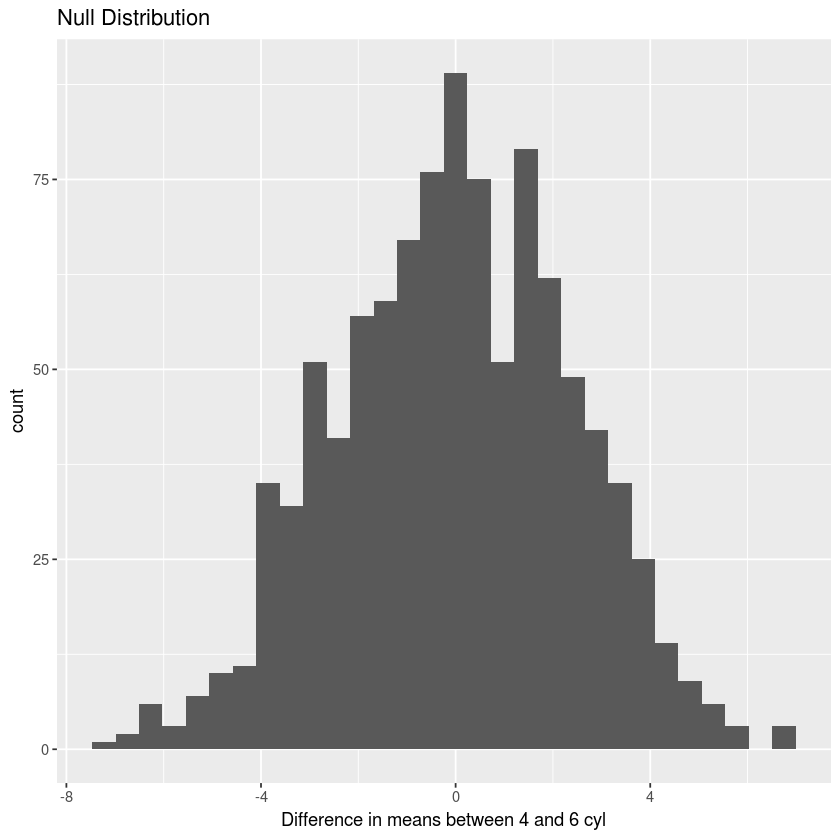

In [21]:
perm_data = mtcars %>%
  filter(cyl != 8) %>% # get only 4 and 6 cyl data
  mutate(cyl = as.factor(cyl)) %>% # data formatting
  specify(mpg ~ cyl) %>% # specify the formula for the mpg against the 2 different groups
  hypothesize(null = "independence") %>% # create Null Hypothesis (no difference between means)
  generate(reps = 1000, type = "permute") %>% # Shuffle labels
  calculate(stat = "diff in means", order = c(4, 6)) # Calculate statistic

perm_data

perm_data %>%
  ggplot(aes(stat)) +
  geom_histogram() +
  xlab("Difference in means between 4 and 6 cyl") +
  ggtitle("Null Distribution")

5. Check whether the originally observed statistic (from the orignial sample) that formed the Alternative Hypothesis is **Significantly Different** from the Null Distribution
    * Significant Difference is detremined from a desired confidence level
    * Using a 95% Confidence Level means that in order to be considered **significantly different** the statistic should be <= 2.5% from the top or bottom of the Null Distribution

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


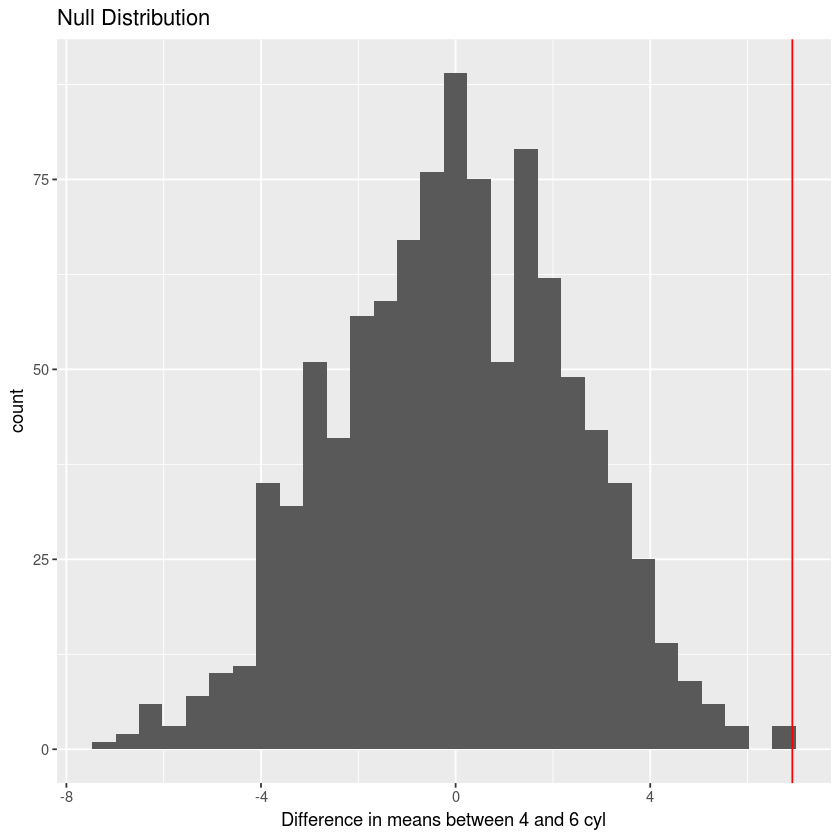

In [22]:
perm_data %>%
  ggplot(aes(stat)) +
  geom_histogram() +
  xlab("Difference in means between 4 and 6 cyl") +
  ggtitle("Null Distribution") +
  geom_vline(aes(xintercept = observed_mean_diff), col = "red")

5. Reject or Accept the Null Hypothesis (Conclusion)


# P-Values

* Probability Value
    * Probability that observed statistic would occur given that the Null Hypothesis were true
    * Probability that the observed statistic DID NOT occur due to random chance

In [23]:
perm_data %>%
  filter(stat > observed_mean_diff) %>%
  summarise(pVal = n()/1000 * 2)

perm_data %>%
  filter(stat > 5) %>%
  summarise(pVal = n()/1000 * 2)

pVal
0


pVal
0.026


# Applications

* Data Exploration

    * Like how we just went through  
    * Testing assumptions

* Modeling Data

    * Create confidence intervals of predictor coefficients

    * Test how significant your model is

* Developing Models

    * Create machine learning models that use these techniques to infer and/or make decisions
